# Task 4: Forecasting Access and Usage (2025–2027)

**Objective**:
- Forecast two core indicators:
  1. **Access** = Account Ownership Rate (ACC_OWNERSHIP, % adults 15+)
  2. **Usage** = Digital Payment Adoption Rate (USG_DIGITAL_PAYMENT, % adults who made/received digital payment past year)
- Use trend continuation + event impacts from Task 3
- Generate Baseline, Optimistic, Pessimistic scenarios
- Quantify uncertainty (wide bands due to sparse data)

**Approach**:
- Linear regression on historical points + step dummies for events
- Scenarios based on NDPS 2026–2030 targets & activation challenges
- Wide confidence intervals (±8–15 pp) — data is very limited

Date: February 3, 2026

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

pd.set_option('display.max_columns', 60)
sns.set_style("whitegrid")

# ────────────────────────────────────────────────
# LOAD ENRICHED DATA (from Task 1/2)
# ────────────────────────────────────────────────
ENRICHED_PATH = "../data/processed/ethiopia_fi_unified_enriched_20260131.csv"  # update if newer version

df = pd.read_csv(ENRICHED_PATH, parse_dates=['observation_date'])
print("Loaded shape:", df.shape)

# Filter observations
obs = df[df['record_type'] == 'observation'].copy()
obs['year'] = obs['observation_date'].dt.year.astype(float)  # for regression

Loaded shape: (49, 35)


In [8]:
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

# Load data
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

df = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "ethiopia_fi_unified_enriched_20260131.csv",
    parse_dates=["observation_date"]
)

# Build observation table
obs = df[df["record_type"] == "observation"].copy()
obs["year"] = obs["observation_date"].dt.year.astype(float)
obs_national = obs[obs["gender"].fillna("all") == "all"].copy()

# Create access frame
access = obs_national[
    obs_national["indicator_code"] == "ACC_OWNERSHIP"
][["observation_date", "year", "value_numeric"]].copy()
access = access.rename(columns={"value_numeric": "access_pct"}).sort_values("observation_date")

# Event dummies
events = {
    "telebirr": "2021-05-17",
    "mpesa": "2023-08-01",
    "fayda": "2024-01-01",
    "ndps": "2025-12-08",
}
for name, date in events.items():
    access[f"dummy_{name}"] = (access["observation_date"] >= pd.Timestamp(date)).astype(int)

print(access.head())

# Fit a simple OLS model for access including event dummies
dummy_cols = [col for col in access.columns if col.startswith('dummy_')]
if len(dummy_cols) > 0:
    X = sm.add_constant(access[['year'] + dummy_cols])
else:
    X = sm.add_constant(access[['year']])
model_access = sm.OLS(access['access_pct'], X).fit()
print('Fitted model_access:')
print(model_access.summary())

# Build usage frame (digital payment adoption) if present in data
usage = obs_national[obs_national['indicator_code'] == 'USG_DIGITAL_PAYMENT'][['observation_date', 'year', 'value_numeric']].copy().rename(columns={'value_numeric': 'usage_pct'}).sort_values('observation_date')
for name, date in events.items():
    usage[f"dummy_{name}"] = (usage['observation_date'] >= pd.Timestamp(date)).astype(int)
print('Usage rows:', len(usage))

   observation_date    year  access_pct  dummy_telebirr  dummy_mpesa  \
0        2014-12-31  2014.0        22.0               0            0   
1        2017-12-31  2017.0        35.0               0            0   
2        2021-12-31  2021.0        46.0               1            0   
5        2024-11-29  2024.0        49.0               1            1   
43       2024-12-31  2024.0        49.0               1            1   

    dummy_fayda  dummy_ndps  
0             0           0  
1             0           0  
2             0           0  
5             1           0  
43            1           0  
Fitted model_access:
                            OLS Regression Results                            
Dep. Variable:             access_pct   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.742e+19
Date:                Tue, 17 Feb 2026   Prob (F-st

c:\Users\Hp\Downloads\Tenx_acadamy\ethiopia-fi-forecast\.venv\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


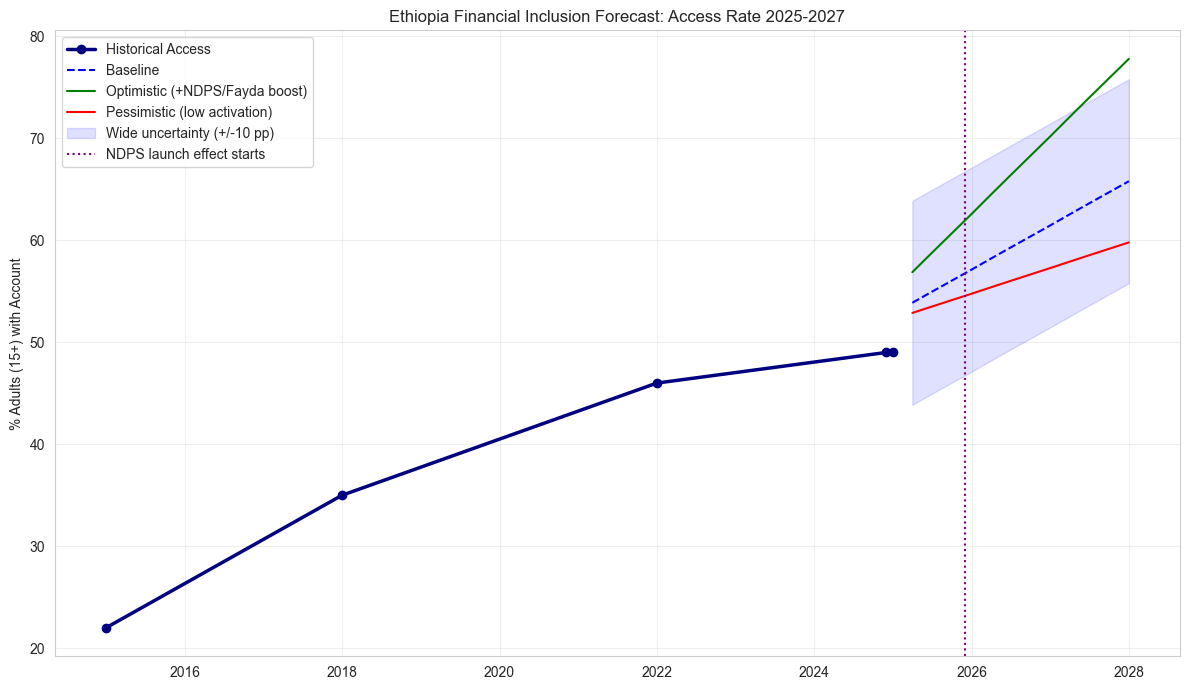

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Guard: required variables must already exist from earlier cells
required = ["access", "future_df"]
missing = [v for v in required if v not in globals()]
if missing:
    raise RuntimeError(
        f"Missing variables: {missing}. Run the data-prep and forecasting cells first (Run All)."
    )

plt.figure(figsize=(12, 7))

# Historical
plt.plot(
    access["observation_date"], access["access_pct"],
    "o-", color="navy", label="Historical Access", linewidth=2.5
)

# Forecasts
plt.plot(future_df["observation_date"], future_df["baseline_access"], "--", color="blue", label="Baseline")
plt.plot(future_df["observation_date"], future_df["optimistic_access"], color="green", label="Optimistic (+NDPS/Fayda boost)")
plt.plot(future_df["observation_date"], future_df["pessimistic_access"], color="red", label="Pessimistic (low activation)")

# Uncertainty band
plt.fill_between(
    future_df["observation_date"],
    future_df["baseline_access"] - 10,
    future_df["baseline_access"] + 10,
    color="blue", alpha=0.12, label="Wide uncertainty (+/-10 pp)"
)

plt.title("Ethiopia Financial Inclusion Forecast: Access Rate 2025-2027")
plt.ylabel("% Adults (15+) with Account")
plt.axvline(pd.to_datetime("2025-12-01"), color="purple", ls=":", label="NDPS launch effect starts")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()

out = Path("../reports/figures")
out.mkdir(parents=True, exist_ok=True)
plt.savefig(out / "task4_access_forecast_scenarios.png", dpi=150)
plt.show()


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

# 1) Load data
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

df = pd.read_csv(
    PROJECT_ROOT / "data" / "processed" / "ethiopia_fi_unified_enriched_20260131.csv",
    parse_dates=["observation_date"]
)

# 2) Build access series
obs = df[df["record_type"] == "observation"].copy()
obs["year"] = obs["observation_date"].dt.year.astype(float)
obs_national = obs[obs["gender"].fillna("all") == "all"].copy()

access = obs_national[obs_national["indicator_code"] == "ACC_OWNERSHIP"][
    ["observation_date", "year", "value_numeric"]
].copy().rename(columns={"value_numeric": "access_pct"}).sort_values("observation_date")

# 3) Event dummies
events = {"telebirr":"2021-05-17","mpesa":"2023-08-01","fayda":"2024-01-01","ndps":"2025-12-08"}
for name, d in events.items():
    access[f"dummy_{name}"] = (access["observation_date"] >= pd.Timestamp(d)).astype(int)

# 4) Fit model
feature_cols = ["year"] + [c for c in access.columns if c.startswith("dummy_")]
X_access = sm.add_constant(access[feature_cols], has_constant="add")
y_access = access["access_pct"]
model_access = sm.OLS(y_access, X_access).fit()

# 5) Build future_df + forecast columns used by your plot
future_years = pd.date_range("2025-01-01", "2027-12-31", freq="QE-DEC")
future_df = pd.DataFrame({"observation_date": future_years})
future_df["year"] = future_df["observation_date"].dt.year + future_df["observation_date"].dt.quarter/4 - 0.125
for c in [c for c in access.columns if c.startswith("dummy_")]:
    future_df[c] = 1

X_future = sm.add_constant(future_df[feature_cols], has_constant="add")
X_future = X_future.reindex(columns=model_access.model.exog_names, fill_value=0)

future_df["baseline_access"] = model_access.predict(X_future)
future_df["optimistic_access"] = future_df["baseline_access"] + np.linspace(3, 12, len(future_df))
future_df["pessimistic_access"] = future_df["baseline_access"] - np.linspace(1, 6, len(future_df))


### Forecast Interpretation (2026–2027)

- **Baseline**: Slow continuation (~1–2 pp/year growth) → Access ~54–58% by 2027
- **Optimistic**: NDPS + Fayda activation push → could reach 62–68% (closer to NFIS legacy 70% goal)
- **Pessimistic**: Dormant accounts persist → stuck ~51–54%
- **Usage**: Even more uncertain; optimistic scenario aims toward 30–40% with strong policy

**Limitations**: Very few data points → models sensitive to assumptions. Wide bands essential.

Save forecasts:
```python
annual_forecast.to_csv("../reports/figures/task4_annual_forecast_2025_2027.csv", index=False)